# Ealy drivers perturbation prediction

#### Analysis early driver including nr2f5,sox9b,twist1b,ets1

In [4]:
import numpy as np
import pandas as pd
import torch
import scanpy as sc
import scvelo as scv
import scipy
import scvi

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

from regvelo import REGVELOVI
import cellrank as cr

import shutil

from rgv_tools import DATA_DIR,FIG_DIR
from rgv_tools.benchmarking import (
    set_output,
)
from rgv_tools.perturbation import abundance_test,DEG,in_silico_block_simulation
from rgv_tools.plotting import bar_scores

In [5]:
scvi.settings.seed = 0

[rank: 0] Global seed set to 0


## Constants

In [7]:
DATASET = "zebrafish"

In [8]:
SAVE_DATA = True
if SAVE_DATA:
    (DATA_DIR / DATASET / "processed").mkdir(parents=True, exist_ok=True)
    (DATA_DIR / DATASET / "results").mkdir(parents=True, exist_ok=True)
    
SAVE_FIGURES = True
if SAVE_FIGURES:
    (FIG_DIR / DATASET).mkdir(parents=True, exist_ok=True)

## Data Loading

In [9]:
adata = sc.read_h5ad(DATA_DIR / DATASET / "processed" / "adata_run_regvelo.h5ad")

In [6]:
genes = ["nr2f5","sox9b","twist1b","ets1"]

## Calculate cell fate probability

In [7]:
terminal_states = [
        "mNC_head_mesenchymal",
        "mNC_arch2",
        "mNC_hox34",
        "Pigment",
    ]

vk = cr.kernels.VelocityKernel(adata)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
g_raw = cr.estimators.GPCCA(vk)
## evaluate the fate prob on original space
g_raw.compute_macrostates(n_states=8,cluster_key="cell_type")
g_raw.set_terminal_states(terminal_states)
g_raw.compute_fate_probabilities()

100%|██████████| 697/697 [00:00<00:00, 893.58cell/s]


Defaulting to `'gmres'` solver.


100%|██████████| 4/4 [00:00<00:00, 95.09/s]


## Visualize gene expression

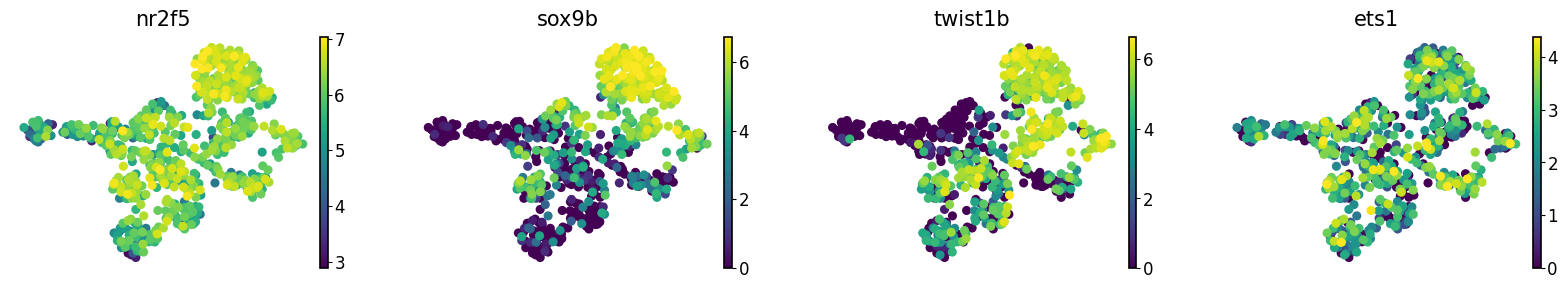

In [8]:
with mplscience.style_context():
    fig, ax = plt.subplots(1,4,figsize=(20,3))
    for axis, gene in zip(ax, genes):
        axis = sc.pl.umap(
            adata, 
            color=[gene],
            vmin="p1",
            vmax="p99",
            frameon=False,
            legend_fontsize=14,
            show=False,
            ax=axis
        )
        
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / DATASET / 'gene_expression.svg',
            format = 'svg',
            transparent = True,
            bbox_inches = 'tight'
        )
    plt.show()

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:900: UserWarning: 
The palette list has fewer values (1) than needed (6) and will cycle, which may produce an uninterpretable plot.
  ax = sns.violinplot(
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:900: UserWarning: 
The palette list has fewer values (1) than needed (6) and will cycle, which may produce an uninterpretable plot.
  ax = sns.violinplot(
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:900: UserWarning: 
The palette list has fewer values (1) than needed (6) and will cycle, which may produce an uninterpretable plot.
  ax = sns.violinplot(
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:900: UserWarning: 
The palette list has fewer values (1) than needed (6) and will cycle, which may produce 

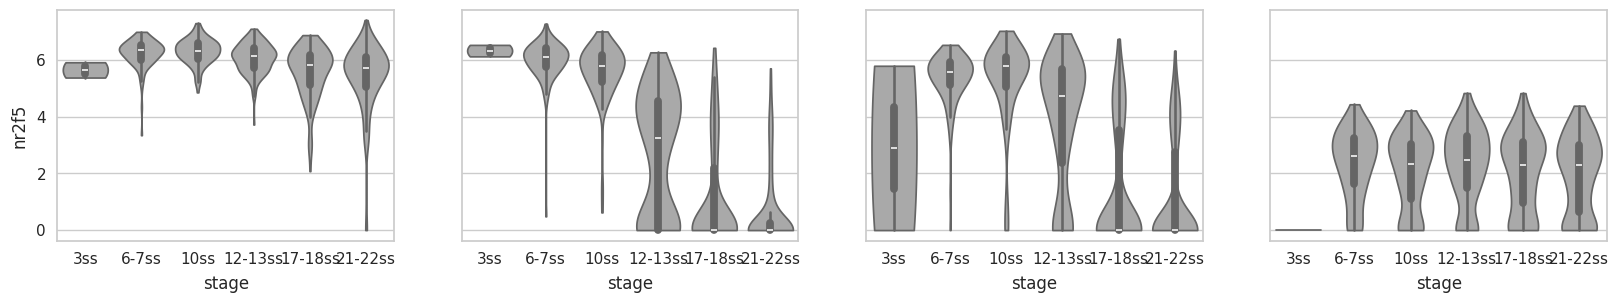

In [9]:
order = ["3ss","6-7ss","10ss","12-13ss","17-18ss","21-22ss"]

with mplscience.style_context():
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(1,4,figsize=(20,3),sharey = True)
    
    for axis, gene in zip(ax, genes):
        axis = sc.pl.violin(
            adata,
            [gene],
            groupby="stage",
            stripplot=False,  # remove the internal dots
            inner="box",  # adds a boxplot inside violins
            order = order,
            palette=['darkgrey'],
            show = False,
            ax = axis
        )
    
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / DATASET / 'gene_expression_time.svg',
            format = 'svg',
            transparent = True,
            bbox_inches = 'tight'
        )
    plt.show()

In [10]:
coord = [[-0.3,0.35,0.25],
         [-3.5,3.5,2.5],
         [-3.5,3.5,2.5],
         [-0.9,1,0.7]]

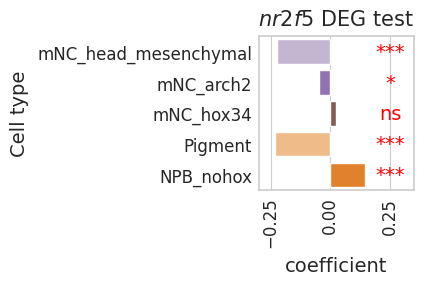

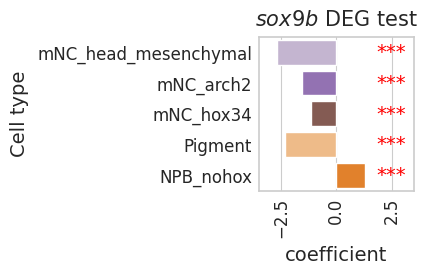

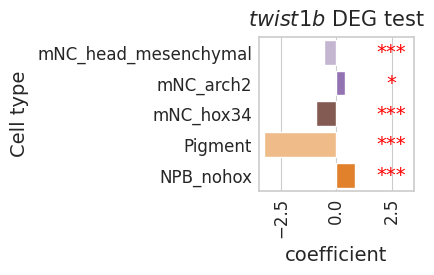

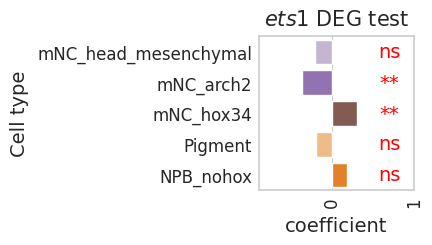

In [11]:
for i,gene in enumerate(genes):
    Gep = adata[:,gene].X.A
    res = DEG(Gep,adata.obs["cell_type"].tolist())
    res.index = res.loc[:,"cell_type"]
    res.columns = ["gene","cell_type","coefficient","pvalue"]
    res = res.loc[["mNC_head_mesenchymal","mNC_arch2","mNC_hox34","Pigment","NPB_nohox"],:].copy()
    bar_scores(res,adata,"cell_type",gene,figsize=(2, 2),title = "DEG test", min = coord[i][0],max = coord[i][1],loc = coord[i][2])

    with mplscience.style_context():
        sns.set(style="whitegrid")
        
        if SAVE_FIGURES:
            plt.savefig(
                        FIG_DIR / DATASET / f'{gene}_DEG.svg',
                        format="svg",
                        transparent=True,
                        bbox_inches='tight'
                    )
            plt.show()

In [12]:
coord = [[-0.25,0.5,0.4],
         [-0.25,0.5,0.4],
         [-0.4,0.5,0.4],
         [-0.25,0.5,0.4]]

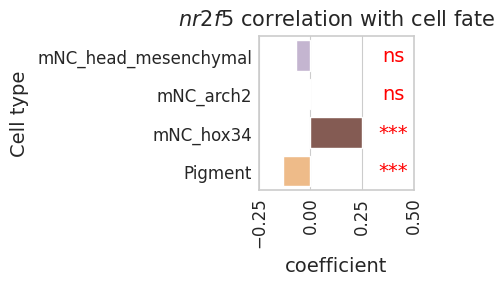

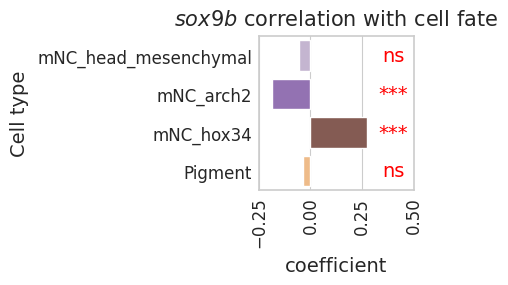

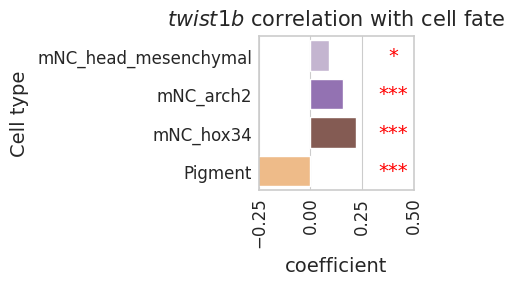

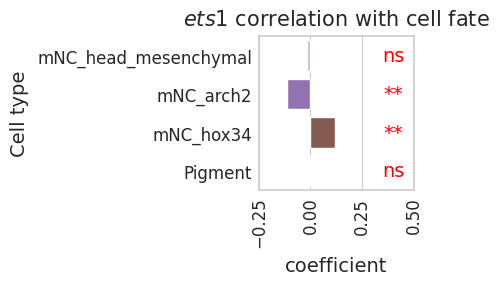

In [13]:
for i,gene in enumerate(genes):
    Gep = adata[:,gene].X.A.reshape(-1)
    score = []
    pvalue = []
    for i in range(adata.obsm["lineages_fwd"].shape[1]):
        score.append(scipy.stats.pearsonr(pd.DataFrame(adata.obsm["lineages_fwd"]).iloc[:,i],Gep)[0])
        pvalue.append(scipy.stats.pearsonr(pd.DataFrame(adata.obsm["lineages_fwd"]).iloc[:,i],Gep)[1])

    test_result = pd.DataFrame({"coefficient":score,"pvalue":pvalue})
    test_result.index = adata.obsm["lineages_fwd"].names.tolist()
    test_result = test_result.loc[["mNC_head_mesenchymal","mNC_arch2","mNC_hox34","Pigment"],:].copy()
    bar_scores(test_result,adata,"cell_type",gene,figsize=(2, 2),min = coord[i][0],max = coord[i][1],loc = coord[i][2])

    with mplscience.style_context():
        sns.set(style="whitegrid")
        if SAVE_FIGURES:
            plt.savefig(
                        FIG_DIR / DATASET / f'{gene}_cor.svg',
                        format="svg",
                        transparent=True,
                        bbox_inches='tight'
                    )
        plt.show()

## Showing the density plot

### perform driver analysis

In [14]:
df = g_raw.compute_lineage_drivers(
    cluster_key="cell_type"
)

## show ranking

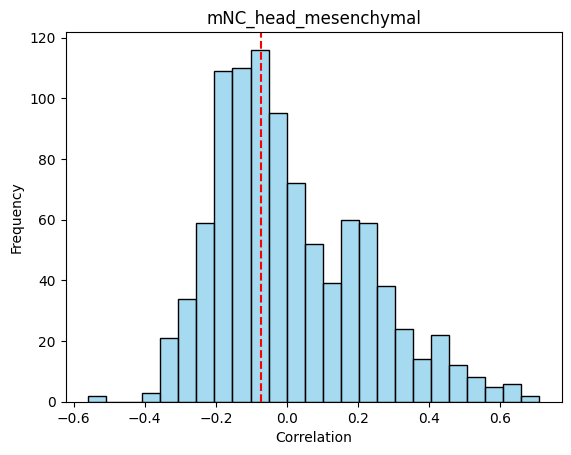

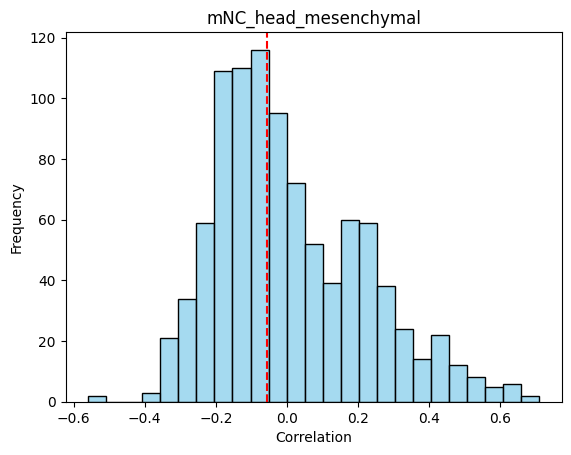

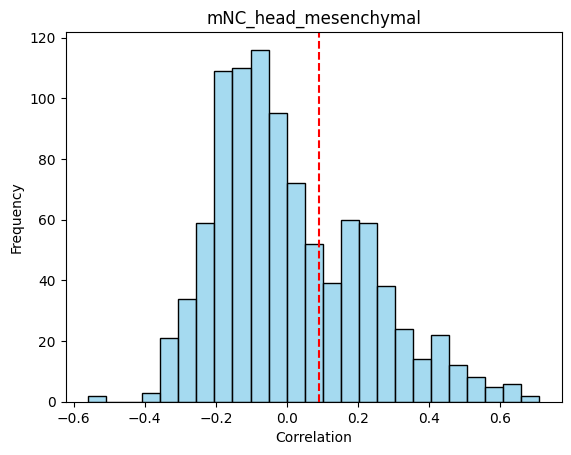

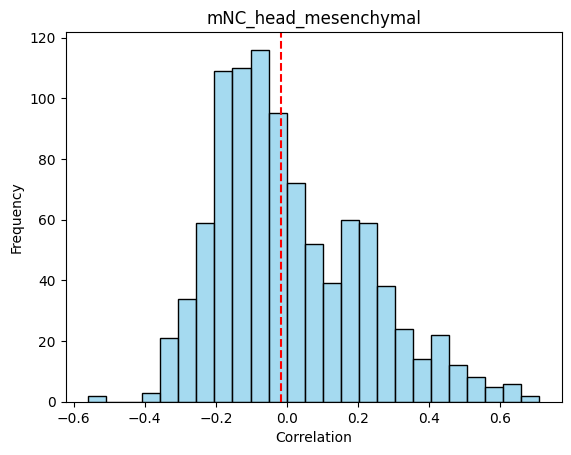

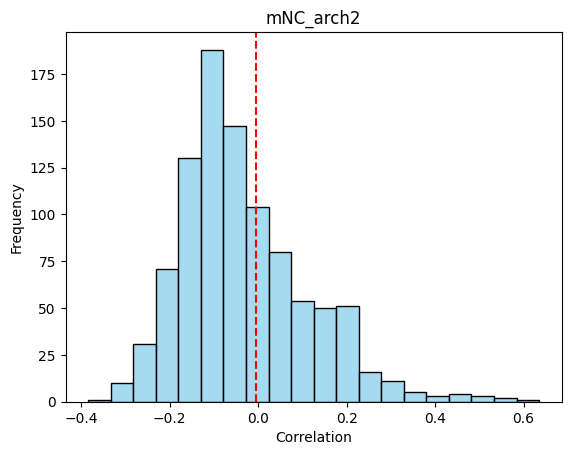

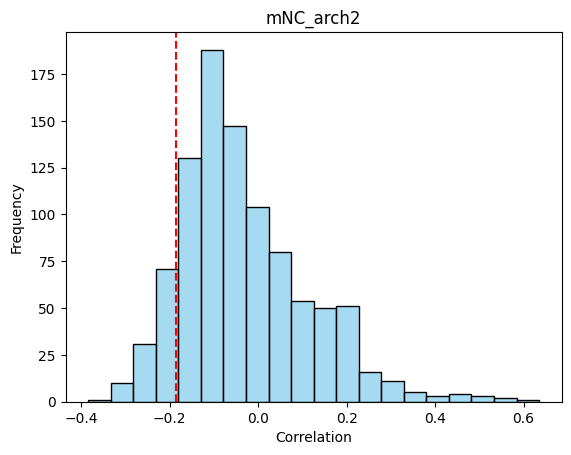

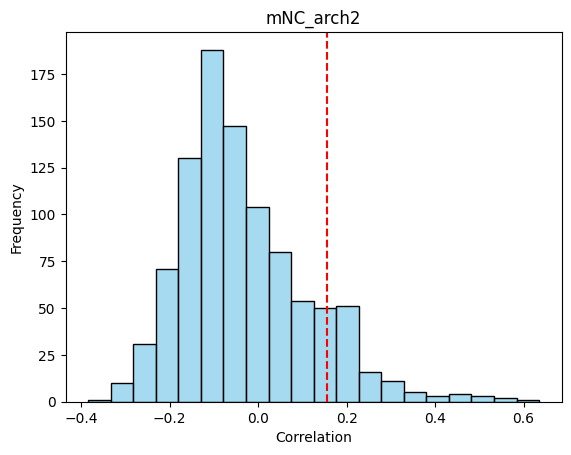

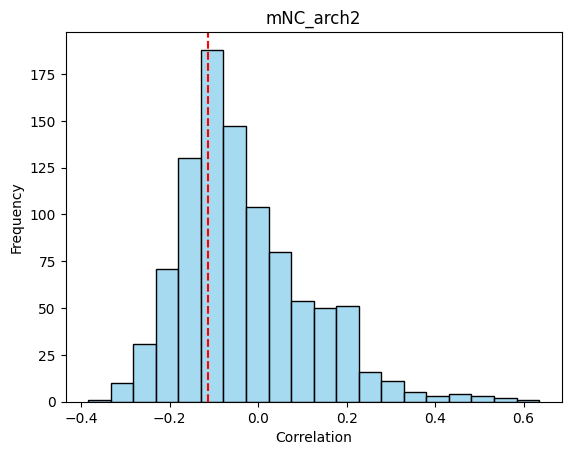

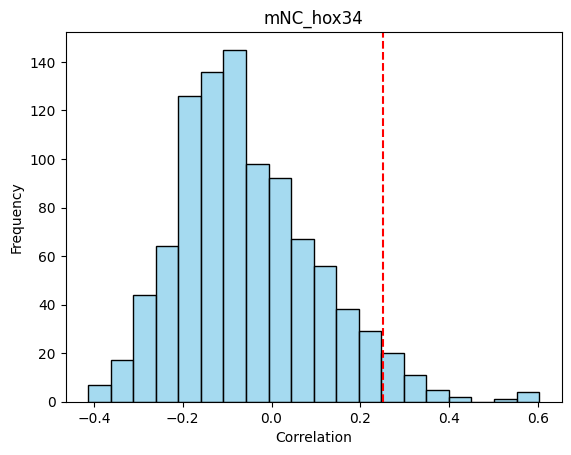

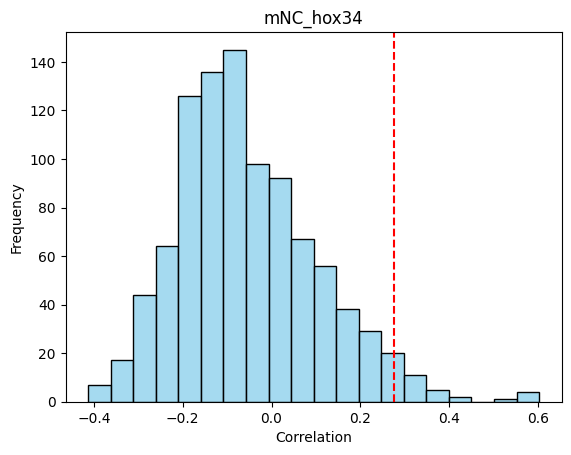

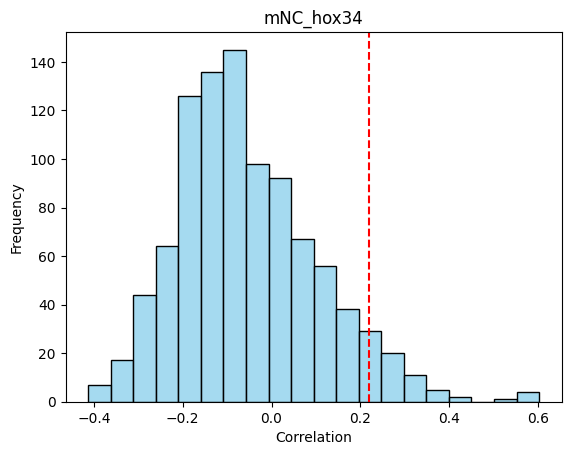

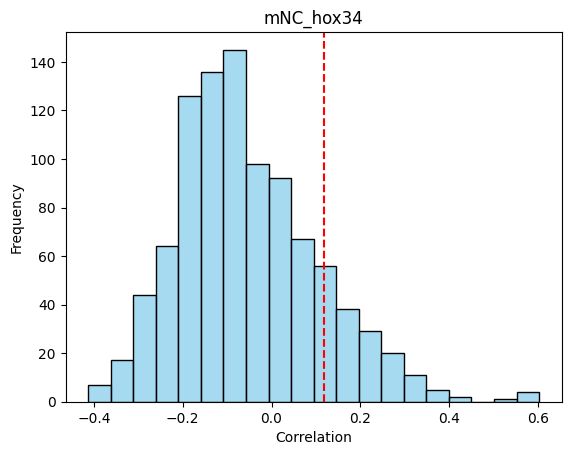

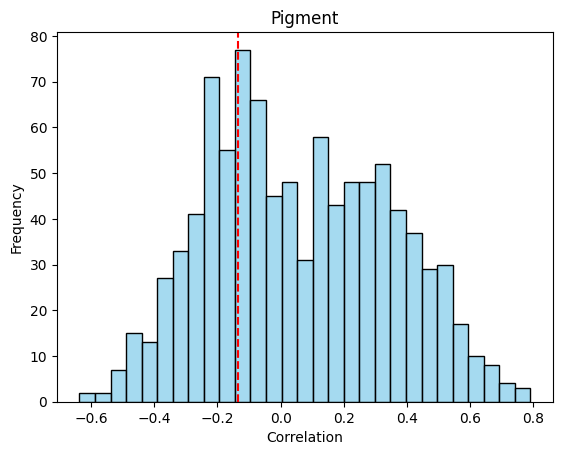

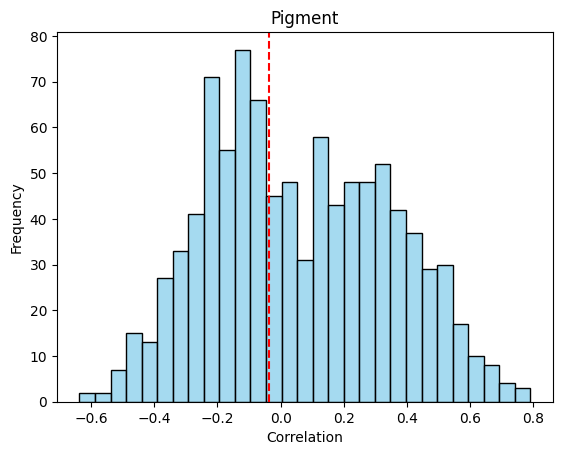

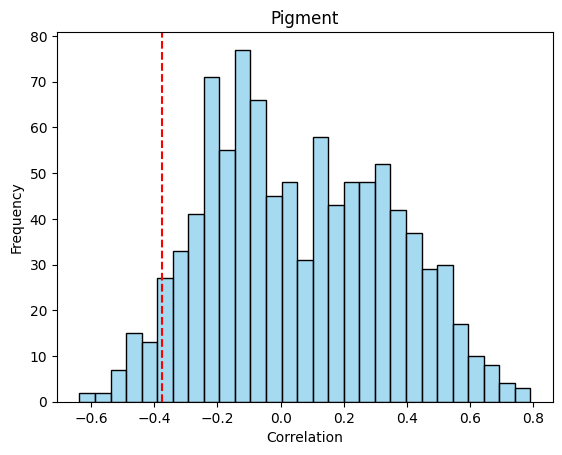

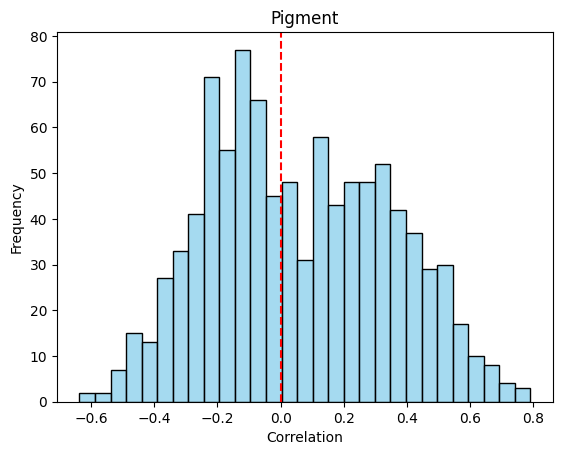

In [15]:
for ts in adata.obsm["lineages_fwd"].names.tolist():
    for gene in genes:
        sns.histplot(df.loc[:,f"{ts}_corr"], color='skyblue', binwidth=0.05)
        # Add a vertical line at x=0.5
        plt.axvline(x=df.loc[gene,f"{ts}_corr"], color='red', linestyle='--')
        # Add labels and title
        plt.xlabel('Correlation')
        plt.ylabel('Frequency')
        plt.title(ts)
        # Show plot

        if SAVE_FIGURES:
            plt.savefig(
                        FIG_DIR / DATASET / f"{gene}_{ts}.svg",
                        format="svg",
                        transparent=True,
                        bbox_inches='tight'
                    )
        plt.show()
        # Close the plot to free up memory
        plt.close()

## Applying RegVelo for perturbation prediction

In [14]:
model = DATA_DIR / DATASET / 'processed' / 'rgv_model'
vae = REGVELOVI.load(model,adata)
set_output(adata, vae, n_samples=30, batch_size=adata.n_obs)

INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(


100%|██████████| 697/697 [00:00<00:00, 1806.72cell/s]


100%|██████████| 4/4 [00:00<00:00, 64.12/s]


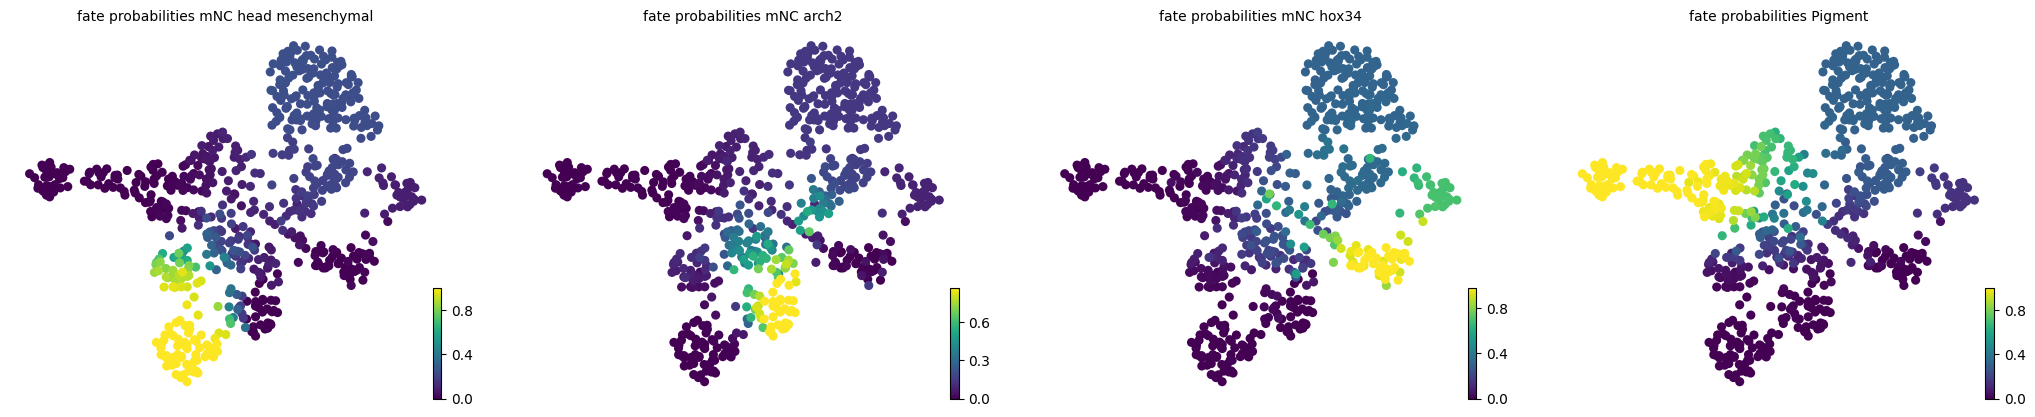

INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1871.37cell/s]


100%|██████████| 4/4 [00:00<00:00, 98.18/s]

INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 2295.19cell/s]


100%|██████████| 4/4 [00:00<00:00, 70.46/s]

INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 2400.75cell/s]


100%|██████████| 4/4 [00:00<00:00, 71.56/s]

INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 2232.55cell/s]


100%|██████████| 4/4 [00:00<00:00, 69.34/s]

INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 1530.77cell/s]


100%|██████████| 4/4 [00:00<00:00, 66.08/s]

INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 2281.02cell/s]


100%|██████████| 4/4 [00:00<00:00, 71.18/s]

INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 2303.25cell/s]


100%|██████████| 4/4 [00:00<00:00, 89.08/s]

INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 2244.78cell/s]


100%|██████████| 4/4 [00:00<00:00, 70.87/s]

INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 2405.75cell/s]


100%|██████████| 4/4 [00:00<00:00, 66.55/s]

INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 697/697 [00:00<00:00, 2322.36cell/s]


100%|██████████| 4/4 [00:00<00:00, 64.39/s]


In [15]:
terminal_states = [
        "mNC_head_mesenchymal",
        "mNC_arch2",
        "mNC_hox34",
        "Pigment",
    ]
vk = cr.kernels.VelocityKernel(adata)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
g_raw = cr.estimators.GPCCA(0.8*vk+0.2*ck)
## evaluate the fate prob on original space
g_raw.compute_macrostates(n_states=8,cluster_key="cell_type")
g_raw.set_terminal_states(terminal_states)
g_raw.compute_fate_probabilities()
g_raw.plot_fate_probabilities(same_plot=False)

fate_prob_perturb = []
cand_list = ["ets1","nr2f2","nr2f5","sox9b","twist1a","twist1b","sox10","mitfa","tfec","tfap2b"]
for TF in cand_list:
    adata_target_perturb,reg_vae_perturb =  in_silico_block_simulation(model,adata,TF)
    
    n_states = 8
    vk = cr.kernels.VelocityKernel(adata_target_perturb)
    vk.compute_transition_matrix()
    ck = cr.kernels.ConnectivityKernel(adata_target_perturb).compute_transition_matrix()
    g = cr.estimators.GPCCA(0.8*vk+0.2*ck)
    ## evaluate the fate prob on original space
    g.compute_macrostates(n_states=n_states,cluster_key="cell_type")
    g.set_terminal_states(terminal_states)
    g.compute_fate_probabilities()
    ## visualize coefficient
    cond1_df = pd.DataFrame(adata_target_perturb.obsm["lineages_fwd"], columns=adata_target_perturb.obsm["lineages_fwd"].names.tolist())

    fate_prob_perturb.append(cond1_df)

cond2_df = pd.DataFrame(adata.obsm["lineages_fwd"], columns=adata.obsm["lineages_fwd"].names.tolist())
df_list = []
for i in range(len(fate_prob_perturb)):
    data = abundance_test(cond2_df, fate_prob_perturb[i])
    data = pd.DataFrame({"Score": data.iloc[:,0].tolist(),
                     "p-value": data.iloc[:,1].tolist(),
                     "Terminal state": data.index.tolist(),
                     "TF":[cand_list[i]]*(data.shape[0])})
    df_list.append(data)

df = pd.concat(df_list)

In [16]:
final_df = df.copy()
final_df["Score"] = 0.5 - final_df["Score"]

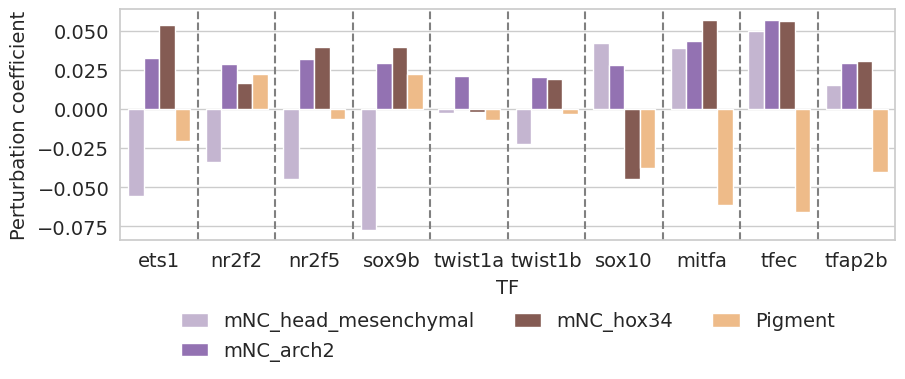

In [19]:
# Create a DataFrame for easier plotting
with mplscience.style_context():
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(10,3))
    #sns.barplot(x='Terminal state', y='AUROC',data=data, hue = "Method",palette=pal,ax = ax)
    color_label = "cell_type"
    palette = dict(zip(adata.obs[color_label].cat.categories, adata.uns[f"{color_label}_colors"]))
    subset_palette = {name: color for name, color in palette.items() if name in cond2_df.columns.tolist()}

    sns.barplot(x='TF', y='Score', hue='Terminal state', data=final_df, ax=ax, palette=palette, dodge=True)

    # Add vertical lines to separate groups
    for i in range(len(final_df['TF'].unique()) - 1):
        plt.axvline(x=i + 0.5, color='gray', linestyle='--')

    # Label settings
    plt.ylabel('Perturbation coefficient', fontsize=14)
    plt.xlabel('TF', fontsize=14)
    plt.xticks(fontsize=14)  # Increase font size of x-axis tick labels
    plt.yticks(fontsize=14)  # Increase font size of y-axis tick labels

    # Customize the legend
    plt.legend(loc='lower center', fontsize = 14, bbox_to_anchor=(0.5,-0.6), ncol=3)

    if SAVE_FIGURES:
        plt.savefig(
                FIG_DIR / DATASET / "driver_perturbation_simulation_all.svg",
                format="svg",
                transparent=True,
                bbox_inches='tight'
            )
    # Show the plot
    plt.show()